On importe la library comme à constantinople

In [1]:

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model
import time
import glob
from IPython import display

In [3]:

tf.config.experimental.set_visible_devices([], 'GPU')


In [4]:
print(tf.config.list_physical_devices('GPU'))

[]


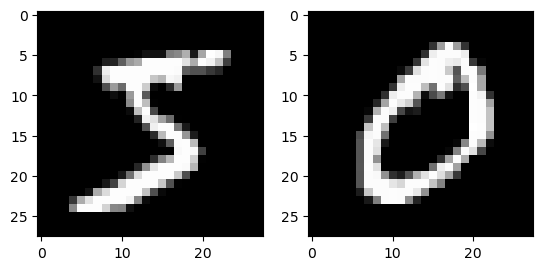

60000

In [5]:
##Importation des données
noise_dim=100
batch_size=64
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Charger les données MNIST

# Obtenir les indices des images de 2 dans l'ensemble d'entraînement
two_indices = np.where(y_train == 1)[0]
two_indices_test= np.where(y_test == 1)[0]
# Sélectionner les images de 2 dans l'ensemble d'entraînement
x_train_two = x_train[two_indices]

y_train_two = y_train[two_indices]

x_test_two = x_test[two_indices_test]

y_test_two = y_test[two_indices_test]

# Normaliser les données d'entraînement et de test


# Redimensionner les données d'entraînement et de test en forme (batch_size, 28, 28, 1)

x_train = x_train.reshape((-1, 28, 28, 1)).astype('float32')
x_train = (x_train-127.5) / 127.5

x_test = x_test_two.reshape((-1, 28, 28, 1)).astype('float32')
x_test = (x_test_two-127.5) / 127.5
plt.subplot(1, 2, 1)
plt.imshow(x_train[0], cmap='gray')

# Afficher l'image de x_train
plt.subplot(1, 2, 2)
plt.imshow(x_train[1], cmap='gray')
plt.show()


len(x_train)

Création de la fonction qui va permettre d'inistialiser pour accélerer la convergence

In [18]:
from keras.initializers import RandomNormal

def custom_weight_init(shape, dtype=None):
    return RandomNormal(mean=0.0, stddev=0.02)(shape, dtype=dtype)


custom_weight_init([12],None)
tf.random.normal([64],mean=0.0, stddev=0.02)


<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 0.00356272, -0.00053918,  0.00423446, -0.04776777,  0.00919805,
        0.01471738,  0.01936403,  0.01713971,  0.01342652,  0.0069612 ,
        0.01013177,  0.00855447, -0.01309479, -0.01702153,  0.03549215,
        0.01534167,  0.02023241, -0.01043453, -0.01494833, -0.01033945,
        0.02453425, -0.00277355,  0.00956197,  0.01905933, -0.00956217,
        0.00269292,  0.00289349, -0.0078021 ,  0.00012027, -0.01328054,
       -0.00214212,  0.01734813,  0.02797932,  0.00101757,  0.01499579,
        0.02387935,  0.01660596, -0.03197792,  0.03097966,  0.03186571,
       -0.02941082, -0.02655528,  0.02526032, -0.00351638,  0.01465584,
        0.00795692, -0.06178542,  0.00621278,  0.00592973, -0.00474318,
       -0.00869164, -0.02802725, -0.00317072, -0.00919626,  0.00210267,
       -0.01381558, -0.02237554, -0.03676623,  0.03217636,  0.00468391,
       -0.00615833,  0.00804718,  0.02468063,  0.01121953], dtype=float32)>

Définition des deux MLP Le premier est le générateur 
Il doit générer des images de taille (28 ,28,1), à partir d'un bruit de taille noise_dim
Le second est le discriminateur, il sort un nombre entre 0 et 1, 1 s'il est sur que l'image est vraie, 0 sinon.
On entraine 'epochs' fois le GAN et à chaque étape on entraine d'abord 
k fois le discriminateur et on entraine 1 fois le générateur à maximiser la valeur du discriminateur appliqué à une de ses images, elle sera alors plus "vrai" aux yeux du discriminateur, qui va de nouveau etre entrainé k fois et ainsi de suite. 
Cela permet d'avoir un générateur entrainé et un discriminateur entrainé si les bons paramètres sont utilisés.



In [76]:

#Définition du générateur generator = tf.keras.Sequential()
generator=tf.keras.Sequential()
generator.add(tf.keras.layers.Dense(7*7*128, input_shape=(noise_dim,),use_bias=False,activation="tanh",kernel_initializer=tf.initializers.random_normal(0.0,0.02)))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.Reshape((7,7 ,128 )))


generator.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same',use_bias=False,kernel_initializer=tf.initializers.random_normal(0.0,0.02)))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))


generator.add(tf.keras.layers.Conv2DTranspose(216, kernel_size=(4,4), strides=(2,2), padding='same',use_bias=False,kernel_initializer=tf.initializers.random_normal(0.0,0.02)))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.Conv2D(1, kernel_size=(7,7), strides=(1,1), padding='same',kernel_initializer=tf.initializers.random_normal(0.0,0.02)))

In [75]:

# Créer le discriminateur# Définition du modèle du discriminator
discriminator = tf.keras.Sequential()

discriminator.add(tf.keras.layers.Conv2D(64, (3, 3),strides=(2,2), padding='same',kernel_initializer=tf.initializers.random_normal(0.0,0.02)))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(tf.keras.layers.Conv2D(32, (3, 3),strides=(2,2), padding='same',kernel_initializer=tf.initializers.random_normal(0.0,0.02)))
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(tf.keras.layers.Dropout(0.3))
discriminator.add(tf.keras.layers.Flatten())
discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compiler le discriminateur avec une fonction de coût binaire croisée et un optimiseur Adam



Compilations:
Recompiler ne reset pas les poids, 
Cela permet d'actualiser les learning rates pour reprendre l'entrainement
ou de changer la loss function


Fonctions de perte utiles à la génération :

In [88]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output,fake_output):
  d_loss_real = tf.keras.losses.MSE(tf.ones_like(real_output),fake_output)
  d_loss_fake = tf.keras.losses.MSE(tf.zeros_like(real_output), fake_output)
  d_loss=d_loss_fake+d_loss_real
  return d_loss


def generate_noise(batch_size, noise_dim):
  return np.random.normal(0, 1, size=(batch_size, noise_dim))

def generator_loss(fake_output):
    return tf.keras.losses.MSE(tf.ones_like(fake_output),fake_output)



noise_dim=100


num_generated_image=16
seed=tf.random.normal([num_generated_image,noise_dim])
sigma=1

g_optimizer=tf.keras.optimizers.Adam(0.07)##8178 bons last
d_optimizer=tf.keras.optimizers.Adam(0.02)## 2242

Définition des batchs:

In [94]:
BUFFER_SIZE=60000
batch_size=64
train_dataset=tf.data.Dataset.from_tensor_slices(x_train)
train_dataset=tf.data.Dataset.shuffle(self=train_dataset,buffer_size=BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)
len(train_dataset)


938

In [70]:

noise_dim=100

epochs=4

num_discriminator_steps_per_epoch=3
num_generator_steps_per_epoch=1

input_shape=(28,28,1)


In [90]:
@tf.function ##Décoration de la tf.fonction pour l'entrainement 
def train_step(image):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        noise = np.random.normal(0,sigma,[batch_size, noise_dim])
        gen_images=generator(noise,training=True)

        real_output=discriminator(image,training=True)
        fake_output=discriminator(gen_images,training=True)

        d_loss=discriminator_loss(real_output=real_output,fake_output=fake_output)
        g_loss=generator_loss(fake_output=fake_output)
        

        gradient_of_discriminator=disc_tape.gradient(d_loss,discriminator.trainable_variables)
        gradient_of_generator=gen_tape.gradient(g_loss,generator.trainable_variables)
        g_optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
        d_optimizer.apply_gradients(zip(gradient_of_discriminator,discriminator.trainable_variables))
    return [g_loss,d_loss]



Boucle d'entrainement, on effectue des batch à partir d'une fonction de génération de batchs définie précédemment ,à chaque itération on fait la fonction next qui prend un autre batch n'ayant pas été utilisé.
Pour num_discriminator_steps_per_epoch on entraine le discriminateur avec des fausse images en réponse des 0 et des vrais images avec en réponses des 1



In [89]:
@tf.function ##Décoration de la tf.fonction pour l'entrainement 
def train_step_discriminator(images,noise):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_images=generator(noise,training=True)

        real_output=discriminator(images,training=True)
        fake_output=discriminator(gen_images,training=True)

        d_loss=discriminator_loss(real_output=real_output,fake_output=fake_output)
        

        gradient_of_discriminator=disc_tape.gradient(d_loss,discriminator.trainable_variables)

    d_optimizer.apply_gradients(zip(gradient_of_discriminator,discriminator.trainable_variables)) 
    
    ## Calcul de la loss post entrainement
    noise = np.random.normal(0,sigma,[batch_size, noise_dim])
    gen_images=generator(noise,training=True)
        
    real_output=discriminator(images,training=True)
    fake_output=discriminator(gen_images,training=True)
   
    d_loss=discriminator_loss(real_output=real_output,fake_output=fake_output)
    
    return d_loss

Entrainement du générateur, sa loss est définie en fonction de l'output du discriminateur, il doit maximiser ce dernier.

In [84]:
@tf.function ##Décoration de la tf.fonction pour l'entrainement 
def train_step_generator(noise):
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_images=generator(noise,training=True)

        
        fake_output=discriminator(gen_images,training=True)
    
        g_loss=generator_loss(fake_output=fake_output)
        

        gradient_of_generator=gen_tape.gradient(g_loss,generator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    
    ## Calcul de la loss post entrainement
    noise = np.random.normal(0,sigma,[batch_size, noise_dim])
    
    gen_images=generator(noise,training=True)
    fake_output=discriminator(gen_images,training=True)
    g_loss=generator_loss(fake_output=fake_output)
    
   
    return g_loss

In [85]:
def generate_and_save_images(model,epoch,test_input):
    predictions=model(test_input,training=True)
    fig=plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
        plt.axis('off')
        
    plt.show()
    

In [92]:
from tqdm import tqdm

def train(dataset,epochs,num_discriminator_steps_per_epoch,num_generator_steps_per_epoch):
    
    for epoch in range(epochs):
        start=time.time()
        
        for image_batch in tqdm(dataset):
            
            for n in range(num_discriminator_steps_per_epoch):
                noise = np.random.normal(0,sigma,[batch_size, noise_dim])
                d_loss=train_step_discriminator(image_batch,noise)
                d_loss=tf.reduce_mean(d_loss).numpy()
                print ("Discriminator step:",n+1,d_loss)
            
            
            for k in range(num_generator_steps_per_epoch):
                noise = np.random.normal(0,sigma,[batch_size, noise_dim])
                g_loss=train_step_generator(noise)
                g_loss=tf.reduce_mean(g_loss).numpy()
                
                
                print ("Generator step:",k+1,g_loss)
            
            g_loss,d_loss=train_step(image_batch)
            D_g_z=tf.reduce_mean(discriminator(generator(seed))).numpy()
            D_x_data=tf.reduce_mean(discriminator(x_test)).numpy()
           
           
            
            display.clear_output(wait=True)
            generate_and_save_images(generator,epochs,test_input=seed)
            print("D(G(z))",D_g_z)
            print("D(x_data)",D_x_data)
            print("GLOSS_mean=",g_loss,"DLOSS_mean=",d_loss)
        
        generate_and_save_images(generator,epochs,test_input=seed)
        return[D_g_z,D_x_data,g_loss.numpy(),d_loss.numpy()]

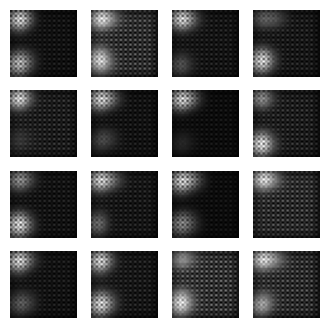

  0%|          | 2/938 [00:06<47:32,  3.05s/it]

D(G(z)) 0.0
D(x_data) 0.0
GLOSS_mean= tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(64,), dtype=float32) DLOSS_mean= tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(64,), dtype=float32)
Discriminator step: 1 1.0


In [95]:
train(dataset=train_dataset,epochs=1,num_discriminator_steps_per_epoch=1,num_generator_steps_per_epoch=1)

In [19]:
discriminator(x_test)

<tf.Tensor: shape=(1135, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)>

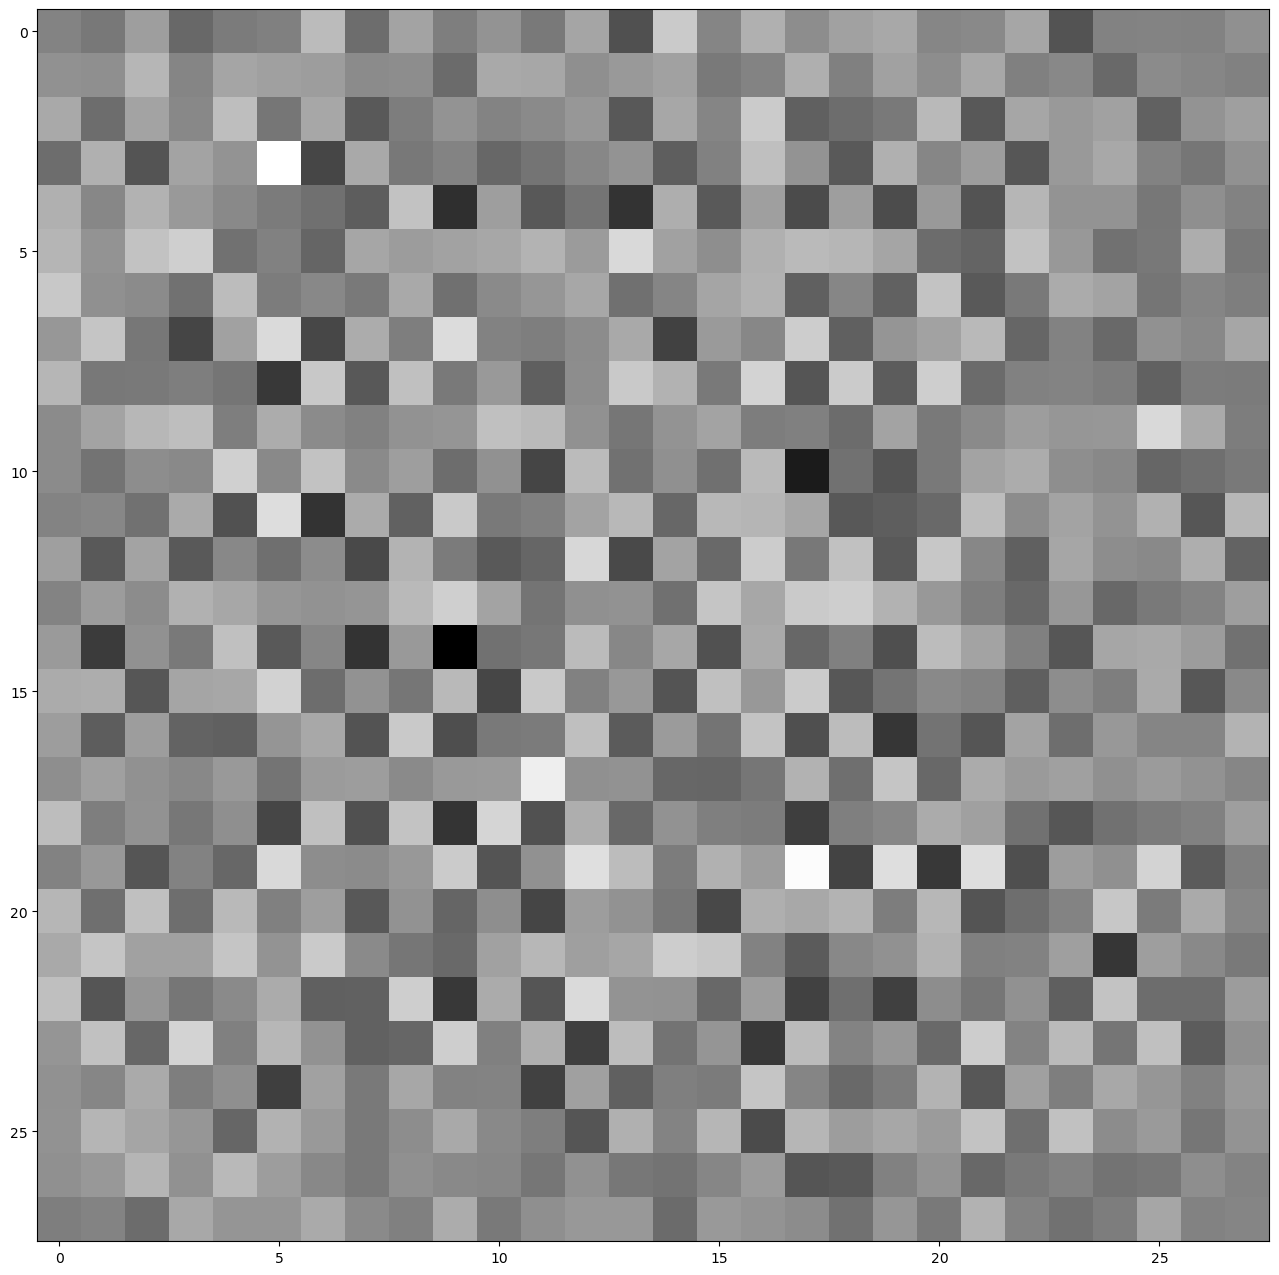

In [67]:
plt.figure(figsize=(16,16))
gen_test=generator(tf.random.normal([batch_size,noise_dim]))
plt.imshow(gen_test[7],cmap='gray')
plt.show()
